Курсовой проект для курса "Python для Data Science" - "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Кузнецов ВВ

1. Загрузка библиотек

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

Загрузка данных

In [2]:
train = pd.read_csv("project_task/train.csv", sep=",")
test = pd.read_csv("project_task/test.csv", sep=",")

Приведение колонок к числовым значениям, декомпозиция значений

In [3]:
class FeatureImputer:
    def colnum(self, X):
        list_column_features = ['Ecology_2', 'Ecology_3', 'Shops_2']
        for c in X.columns[X.dtypes == 'object']:
            X[c] = X[c].factorize()[0]
        year = datetime.date.today().year  
        X['HouseYear'] = year - X['HouseYear']
        X.loc[(X['LifeSquare'].isnull()), 'LifeSquare'] = X['Square']
        X.loc[X['Ecology_2'] == 1, 'Ecology_2'] = 3
        X.loc[X['Ecology_2'] == 0, 'Ecology_2'] = 2
        X.loc[X['Ecology_3'] == 1, 'Ecology_3'] = 3
        X.loc[X['Ecology_3'] == 0, 'Ecology_3'] = 2
        X.loc[X['Helthcare_2'] != -1, 'Helthcare_2'] = (X['Helthcare_2'] + 1) * 10
        X.loc[X['Shops_2'] == 1, 'Shops_2'] = 3
        X.loc[X['Shops_2'] == 0, 'Shops_2'] = 2
        return X
    
    
    def transform(self, X, median):
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = median
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10        
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        current_year = now = datetime.datetime.now().year        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year                
        X.loc[(X['LifeSquare'] > 300) & (X['Square'] > 300), 'LifeSquare']  = X['LifeSquare'] / 10
        X.loc[(X['Square'] > 300), 'Square'] = X['Square']/ 10
        X.loc[(X['LifeSquare'] > 300), 'LifeSquare'] = X['Square']
        X.loc[X['Id'] == 15215, 'Square'] = X['LifeSquare']
        X.loc[X['Ecology_1'] == 0, 'Ecology_1'] = X['Ecology_1'].mean()
        X['Floor'] = X['HouseFloor']
        
        return X

In [4]:
train.loc[train['HouseYear'] < 0, 'HouseYear'] = train['HouseYear'].median()
di = train.groupby(['DistrictId']).mean()['HouseYear']

train['HouseYear_mean'] = train['DistrictId'].map(di)
test['HouseYear_mean'] = test['DistrictId'].map(di)
test.loc[test['HouseYear_mean'].isnull(), 'HouseYear_mean'] = test['HouseYear_mean'].median()

In [5]:
f = FeatureImputer()

In [6]:
train = f.colnum(train)
test = f.colnum(test)
median = train['Rooms'].median()
train = f.transform(train, median)
test = f.transform(test, median)

Проверка на совпаденире колонки DistrictId

In [7]:
for i in test.groupby(['DistrictId']).mean().index.values:
    if(True != (i in train.groupby(['DistrictId']).mean().index.values)):
        print(i)

198
203
204
206
210
211
212


IDE

In [8]:
train['SqM3'] = train['Price'] / train['Square']
di = train.groupby(['DistrictId']).mean()['SqM3']
train['SqM3_mean'] = train['DistrictId'].map(di)
test['SqM3_mean'] = test['DistrictId'].map(di)
test.loc[test['SqM3_mean'].isnull(), 'SqM3_mean'] = test['SqM3_mean'].median()

In [9]:
train.drop(['SqM3'], axis = 1, inplace=True)

Проверка на заполнение

In [10]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseYear_mean,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,SqM3_mean
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,1.000000e+04,1.000000e+04,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000
mean,8383.40770,50.400800,1.887600,56.162732,41.164828,6.616240,12.95910,12.95910,-1.970166e+03,1.252402e-01,...,1142.904460,23.195000,4.231300,2.082500,214138.857399,3990.166300,0.001200,0.182500,0.0,3992.167920
std,4859.01902,43.587592,0.811438,19.156723,20.806081,5.296383,6.44346,6.44346,2.005003e+05,1.156182e-01,...,1021.517264,14.936006,4.806341,0.275139,92872.293865,31250.218894,0.034622,0.386275,0.0,1016.847383
min,0.00000,0.000000,1.000000,1.136859,0.370619,3.000000,1.00000,1.00000,-2.004999e+07,1.800000e-09,...,0.000000,10.000000,0.000000,2.000000,59174.778028,1924.500000,0.000000,0.000000,0.0,2284.108677
25%,4169.50000,20.000000,1.000000,41.771580,25.506959,3.000000,9.00000,9.00000,1.900000e+01,3.465608e-02,...,350.000000,10.000000,1.000000,2.000000,153872.633942,1979.000000,0.000000,0.000000,0.0,3021.675025
50%,8394.50000,36.000000,2.000000,52.509275,37.562685,6.000000,13.00000,13.00000,4.300000e+01,9.079910e-02,...,900.000000,20.000000,3.000000,2.000000,192269.644879,1985.793814,0.000000,0.000000,0.0,4084.464328
75%,12592.50000,75.000000,2.000000,65.889736,50.082176,9.000000,17.00000,17.00000,4.600000e+01,1.957811e-01,...,1548.000000,30.000000,6.000000,2.000000,249135.462171,1990.818004,0.000000,0.000000,0.0,4553.239744
max,16798.00000,209.000000,5.000000,275.645284,263.542020,201.400000,117.00000,117.00000,1.100000e+02,5.218671e-01,...,4849.000000,70.000000,23.000000,3.000000,633233.466570,491010.682927,1.000000,1.000000,0.0,9452.113505


In [11]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,HouseYear_mean,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,SqM3_mean
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,...,5000.000000,2623.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.0,5000.000000
mean,8412.595400,51.279200,1.905800,56.449500,41.165054,6.655000,12.915400,12.915400,35.607400,1.265629e-01,...,8.262600,1146.657263,23.194000,4.242800,2.082400,3843.289687,0.00100,0.176800,0.0,4008.572896
std,4832.674037,44.179466,0.806137,19.092787,20.255970,9.640921,6.468617,6.468617,18.573149,1.164904e-01,...,23.863762,1044.744231,14.799398,4.777365,0.275001,30091.248198,0.03161,0.381538,0.0,1003.899656
min,1.000000,0.000000,1.000000,1.378543,0.333490,3.000000,1.000000,1.000000,0.000000,1.800000e-09,...,0.000000,0.000000,10.000000,0.000000,2.000000,1924.500000,0.00000,0.000000,0.0,2284.108677
25%,4221.750000,21.000000,1.000000,41.906231,25.850152,3.000000,9.000000,9.000000,20.000000,3.612229e-02,...,0.000000,325.000000,10.000000,1.000000,2.000000,1979.269231,0.00000,0.000000,0.0,3089.185017
50%,8320.500000,37.000000,2.000000,52.921340,37.382816,6.000000,12.000000,12.000000,43.000000,9.079910e-02,...,2.000000,900.000000,20.000000,3.000000,2.000000,1985.361963,0.00000,0.000000,0.0,4089.011120
75%,12598.250000,77.000000,2.000000,66.285129,50.611287,9.000000,17.000000,17.000000,47.000000,1.957811e-01,...,5.000000,1548.000000,30.000000,6.000000,2.000000,1990.818004,0.00000,0.000000,0.0,4560.204511
max,16795.000000,212.000000,5.000000,223.453689,169.901701,620.000000,99.000000,99.000000,112.000000,5.218671e-01,...,141.000000,4849.000000,70.000000,23.000000,3.000000,491010.682927,1.00000,1.000000,0.0,9452.113505


In [12]:
test.drop(['HouseYear_outlier'], axis=1, inplace=True)
train.drop(['HouseYear_outlier'], axis=1, inplace=True)

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   float64
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   int64  
 11  Ecology_3           5000 non-null   int64  
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [14]:
train['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [15]:
train['Floor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [16]:
train.loc[(train['Id'] == 6782), 'LifeSquare'] = train.loc[(438000<train['Price']) & (train['Price'] < 440000) & (train['DistrictId'] == 45.0) & (train['Square'] > 5)].iloc[0]['LifeSquare']
train.loc[(train['Id'] == 6782), 'Square'] = train.loc[(438000<train['Price']) & (train['Price'] < 440000) & (train['DistrictId'] == 45.0) & (train['Square'] > 5)].iloc[0]['Square']

In [17]:
restruct_train = train.loc[(train['LifeSquare'].isnull() != True) & (train['Healthcare_1'].isnull() != True)].drop(['Price'], axis=1).drop(['DistrictId'], axis=1)

scaler = StandardScaler()

X_r_train_ls = restruct_train.drop(["LifeSquare", "Healthcare_1"], axis = 1)
y_r_train_ls = restruct_train["Healthcare_1"]

X_train_scaled = scaler.fit_transform(X_r_train_ls)
feature_names = list(X_r_train_ls)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_r_train_ls, test_size=0.2, random_state=42)

In [18]:
model_Healthcare_1 = RandomForestRegressor(max_depth=14, random_state=42, n_estimators=1000)

model_Healthcare_1.fit(X_train, y_train)
y_forest_pred = model_Healthcare_1.predict(X_test)

print('R2 оценка точности')
r2_score(y_test, y_forest_pred)

R2 оценка точности


0.9962262715794393

In [19]:
sq = train.loc[(train['Healthcare_1'].isnull())].drop(["LifeSquare", "Healthcare_1"], axis = 1).drop(['Price'], axis=1).drop(['DistrictId'], axis=1)
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = model_Healthcare_1.predict(sq)

sq = train.loc[(train['Healthcare_1'] > 0)].drop(["LifeSquare", "Healthcare_1"], axis = 1).drop(['Price'], axis=1).drop(['DistrictId'], axis=1)
train.loc[(train['Healthcare_1'] > 0), 'Healthcare_1'] = model_Healthcare_1.predict(sq)


sq = test.loc[(test['Healthcare_1'].isnull())].drop(["LifeSquare", "Healthcare_1"], axis = 1).drop(['DistrictId'], axis=1)
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = model_Healthcare_1.predict(sq)

sq = test.loc[(test['Healthcare_1'] > 0)].drop(["LifeSquare", "Healthcare_1"], axis = 1).drop(['DistrictId'], axis=1)
test.loc[(test['Healthcare_1'] > 0), 'Healthcare_1'] = model_Healthcare_1.predict(sq)

Подготовка модели для предсказания цены 

In [20]:
scaler = StandardScaler()

print(len(train))

X_test_ls = test.drop(["Id"], axis = 1).drop(["Ecology_2"], axis = 1).drop(["Ecology_3"], axis = 1)
X_r_train_ls = train.loc[(train['KitchenSquare'] <= 2000)].drop(["Price"], axis = 1).drop(["Id"], axis = 1)
y_r_train_ls = train.loc[(train['KitchenSquare'] <= 2000)]["Price"]

X_train_scaled = scaler.fit_transform(X_r_train_ls)
feature_names = list(X_r_train_ls)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

10000


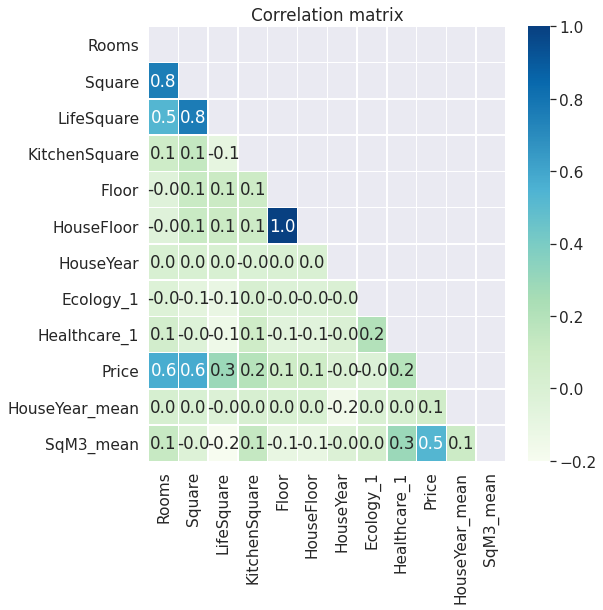

In [21]:
df_num_features = train.select_dtypes(include='float64')
num_features = pd.DataFrame(df_num_features)

corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

Тренировка на модели данных

In [22]:
ac = 0
model_ac = []

for i in range(1):
    model = RandomForestRegressor(max_depth=14, n_estimators=300, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_r_train_ls.drop(["Ecology_2"], axis = 1).drop(["Ecology_3"], axis = 1), y_r_train_ls, test_size=0.20, random_state=42)
    model.fit(X_train, y_train)
    y_forest_pred = model.predict(X_test)

    print('R2 оценка точности')
    r2 = r2_score(y_test, y_forest_pred)
    
    if ac < r2:
        model_ac = model
        ac = r2
    print(r2)
    
print('Выбрана модель с точностью ' + str(ac))

R2 оценка точности
0.7306535168226043
Выбрана модель с точностью 0.7306535168226043


10000


0.7306535168226043

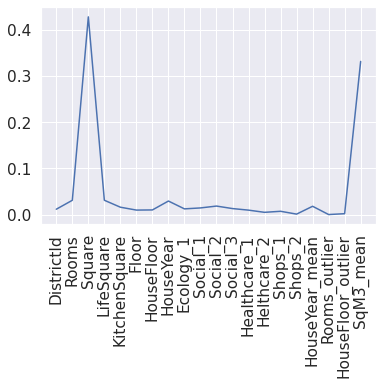

In [23]:
plt.plot(model_ac.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90);
print(len(X_r_train_ls))
r2

In [24]:
y = model.predict(X_test_ls)
X_tarin_l = X_test_ls.copy(deep=True)
X_tarin_l['Id'] = test['Id']
X_tarin_l['Id'].values

d = dict(zip(X_tarin_l['Id'].values, y))
X_tarin_l['Price'] = test['Id'].map(d)
X_tarin_l[['Id', 'Price']].to_csv("KuznetsovVV_predictions.csv", index=False, encoding='utf-8')

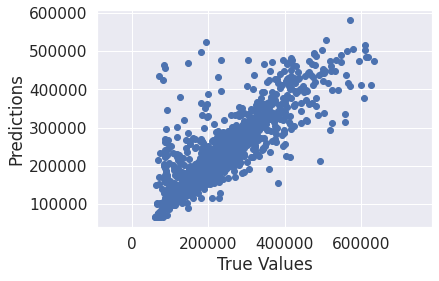

In [25]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

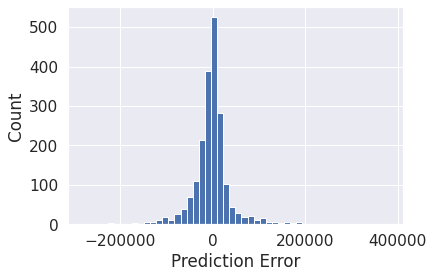

In [26]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

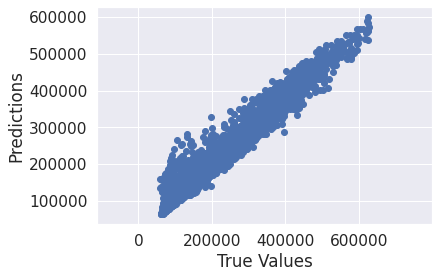

In [27]:
train_predictions = model.predict(X_train).flatten()

plt.scatter(y_train, train_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

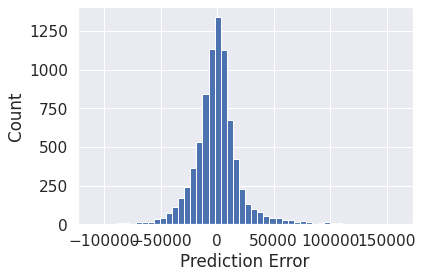

In [28]:
error = train_predictions - y_train
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [29]:
#X_test['Price_pred'] = y_forest_pred.T
#X_test['Price'] = y_test.values
#proc = 0.05
#X_test.loc[((X_test['Price_pred'] / X_test['Price']) <= 0.7) | ((X_test['Price_pred'] / X_test['Price']) >= 1.3)]

In [30]:
#X_test.loc[(0.98 < (X_test['Price_pred'] / X_test['Price'])) & ((X_test['Price_pred'] / X_test['Price']) < 1.02)]



Для примера проверим нейронную сеть



In [31]:
#from future import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.compat.v1 import keras as keras

import numpy as np

print("We're using TF", tf.__version__)

We're using TF 2.3.0


In [40]:
# Тестовые данные не используются при вычислении mean и std

mean = X_train.values.mean(axis=0)
std = X_train.values.std(axis=0)
train_data = (X_train.values - mean) / std
test_data = (X_test.values - mean) / std

train_labels = y_train.values.T / 40000
test_labels = y_test.values.T / 40000

print(train_data[0])  # Первый тренировочный пример, нормализованный

[ 1.24926888 -1.10037119 -1.26777632 -0.96770099 -0.29464088 -1.22755015
 -1.22755015  0.01127091 -0.74231612 -0.09858266 -0.16737193  0.01580894
 -0.47061679  0.13550813  0.2611156   1.11707916 -0.67412635 -0.29986373
 -0.06482552 -0.02959335 -0.4667348   0.66540875]


In [41]:
test_data.shape

(2000, 22)

In [42]:
def build_model():
    X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_r_train_ls, test_size=0.2)
    
    model_nn = keras.Sequential([
                keras.layers.Dense(64, activation='relu',
                                   input_shape=(train_data.shape[1],)),
                keras.layers.Dense(64, activation='sigmoid'),
                keras.layers.Dense(64, activation='sigmoid'),
                keras.layers.Dense(64, activation='sigmoid'),
                keras.layers.Dense(64, activation='sigmoid'),
                keras.layers.Dense(64, activation='sigmoid'),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(1)
              ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.1)

    model_nn.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    return model_nn

model_nn = build_model()
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                1472      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [43]:
#Загрузка модели
#model_nn.load_weights("training_0/cp-2000.ckpt")

In [44]:
test_data

array([[ 1.08903981,  0.13081336,  0.0459826 , ..., -0.02959335,
        -0.4667348 ,  0.30753205],
       [-0.99393813,  0.13081336, -0.84100002, ..., -0.02959335,
        -0.4667348 ,  0.48771514],
       [-1.016828  ,  0.13081336,  0.26749438, ..., -0.02959335,
        -0.4667348 , -0.97719949],
       ...,
       [-0.37591171,  0.13081336,  0.2636501 , ..., -0.02959335,
         2.14254432,  2.34696679],
       [ 1.93596491,  0.13081336, -0.92663641, ..., -0.02959335,
        -0.4667348 ,  1.57094299],
       [-0.53614078,  0.13081336,  0.62421128, ..., -0.02959335,
        -0.4667348 , -1.06743436]])

In [45]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          10000 non-null  float64
 1   Rooms               10000 non-null  float64
 2   Square              10000 non-null  float64
 3   LifeSquare          10000 non-null  float64
 4   KitchenSquare       10000 non-null  float64
 5   Floor               10000 non-null  float64
 6   HouseFloor          10000 non-null  float64
 7   HouseYear           10000 non-null  float64
 8   Ecology_1           10000 non-null  float64
 9   Ecology_2           10000 non-null  float64
 10  Ecology_3           10000 non-null  float64
 11  Social_1            10000 non-null  float64
 12  Social_2            10000 non-null  float64
 13  Social_3            10000 non-null  float64
 14  Healthcare_1        10000 non-null  float64
 15  Helthcare_2         10000 non-null  float64
 16  Shops

In [ ]:
#
#
#Если мало времени то лучше пропустить.
#

In [47]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

list_model = [0]

for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_r_train_ls, test_size=0.2)

    mean = X_train.values.mean(axis=0)
    std = X_train.values.std(axis=0)
    train_data = (X_train.values - mean) / std
    test_data = (X_test.values - mean) / std

    train_labels = y_train.values.T / 40000
    test_labels = y_test.values.T / 40000
    
    # Добавим эпоху в имя файла (uses `str.format`)
    checkpoint_path = "training_0_0/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Создадим коллбек сохраняющий веса модели каждые 5 эпох
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1, 
        save_weights_only=True,
        period=5)    

    # Сохраним веса используя формат `checkpoint_path` format
    model_nn.save_weights(checkpoint_path.format(epoch=0))

    # Отобразим прогресс тренировки 
    # печатая по одной точке на каждую завершенную эпоху 
    class PrintDot(keras.callbacks.Callback):
          def on_epoch_end(self, epoch, logs):
                print('.', end='')

    EPOCHS = 2000

    # Сохраним тренировочную статистику
    history = model_nn.fit(train_data, train_labels, epochs=EPOCHS,
                            validation_data=(test_data, test_labels), callbacks=[cp_callback])

    #clear_output()

    
    def plot_history(history):
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [1000$]')
        plt.plot(history.epoch, 
               np.array(history.history['mae']),
               label='Train Loss')
        plt.plot(history.epoch, 
               np.array(history.history['val_mae']),
               label = 'Val loss')
        plt.legend()
        plt.ylim([0, 3])
    
    #print('epoch'+str(i * EPOCHS))
    
    #plot_history(history)
    
    loss,acc = model_nn.evaluate(test_data, test_labels, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    y_nn_pred = model_nn.predict(test_data)
    
    print('r2 =' + str(r2_score(test_labels, y_nn_pred)))
    print('')

Epoch 1/2000
250/250 [==============================] - 0s 1ms/step - loss: 30.3205 - accuracy: 0.0000e+00 - val_loss: 26.8239 - val_accuracy: 0.0000e+00
Epoch 2/2000
250/250 [==============================] - 0s 742us/step - loss: 23.1515 - accuracy: 0.0000e+00 - val_loss: 19.4657 - val_accuracy: 0.0000e+00
Epoch 3/2000
250/250 [==============================] - 0s 728us/step - loss: 16.2262 - accuracy: 0.0000e+00 - val_loss: 12.9775 - val_accuracy: 0.0000e+00
Epoch 4/2000
250/250 [==============================] - 0s 715us/step - loss: 10.2642 - accuracy: 0.0000e+00 - val_loss: 7.7877 - val_accuracy: 0.0000e+00
Epoch 5/2000
235/250 [===========================>..] - ETA: 0s - loss: 6.4545 - accuracy: 0.0000e+00
Epoch 00005: saving model to training_0_0/cp-0005.ckpt
250/250 [==============================] - 0s 838us/step - loss: 6.3878 - accuracy: 0.0000e+00 - val_loss: 5.4599 - val_accuracy: 0.0000e+00
Epoch 6/2000
250/250 [==============================] - 0s 820us/step - loss: 5.4

166/250 [==================>...........] - ETA: 0s - loss: 5.0474 - accuracy: 0.0000e+00
Epoch 00045: saving model to training_0_0/cp-0045.ckpt
250/250 [==============================] - 0s 760us/step - loss: 5.0486 - accuracy: 0.0000e+00 - val_loss: 4.9807 - val_accuracy: 0.0000e+00
Epoch 46/2000
250/250 [==============================] - 0s 749us/step - loss: 4.9851 - accuracy: 0.0000e+00 - val_loss: 4.9159 - val_accuracy: 0.0000e+00
Epoch 47/2000
250/250 [==============================] - 0s 799us/step - loss: 4.9138 - accuracy: 0.0000e+00 - val_loss: 4.8379 - val_accuracy: 0.0000e+00
Epoch 48/2000
250/250 [==============================] - 0s 766us/step - loss: 4.8271 - accuracy: 0.0000e+00 - val_loss: 4.7433 - val_accuracy: 0.0000e+00
Epoch 49/2000
250/250 [==============================] - 0s 716us/step - loss: 4.7242 - accuracy: 0.0000e+00 - val_loss: 4.6377 - val_accuracy: 0.0000e+00
Epoch 50/2000
249/250 [============================>.] - ETA: 0s - loss: 4.6093 - accuracy: 0.0

250/250 [==============================] - 0s 740us/step - loss: 1.8652 - accuracy: 0.0000e+00 - val_loss: 1.8623 - val_accuracy: 0.0000e+00
Epoch 90/2000
250/250 [==============================] - ETA: 0s - loss: 1.8590 - accuracy: 0.0000e+00
Epoch 00090: saving model to training_0_0/cp-0090.ckpt
250/250 [==============================] - 0s 772us/step - loss: 1.8590 - accuracy: 0.0000e+00 - val_loss: 1.8425 - val_accuracy: 0.0000e+00
Epoch 91/2000
250/250 [==============================] - 0s 744us/step - loss: 1.8522 - accuracy: 0.0000e+00 - val_loss: 1.8372 - val_accuracy: 0.0000e+00
Epoch 92/2000
250/250 [==============================] - 0s 720us/step - loss: 1.8449 - accuracy: 0.0000e+00 - val_loss: 1.8390 - val_accuracy: 0.0000e+00
Epoch 93/2000
250/250 [==============================] - 0s 737us/step - loss: 1.8395 - accuracy: 0.0000e+00 - val_loss: 1.8208 - val_accuracy: 0.0000e+00
Epoch 94/2000
250/250 [==============================] - 0s 716us/step - loss: 1.8330 - accurac

250/250 [==============================] - 0s 774us/step - loss: 1.6836 - accuracy: 0.0000e+00 - val_loss: 1.6743 - val_accuracy: 0.0000e+00
Epoch 134/2000
250/250 [==============================] - 0s 740us/step - loss: 1.6814 - accuracy: 0.0000e+00 - val_loss: 1.6599 - val_accuracy: 0.0000e+00
Epoch 135/2000
171/250 [===================>..........] - ETA: 0s - loss: 1.7488 - accuracy: 0.0000e+00
Epoch 00135: saving model to training_0_0/cp-0135.ckpt
250/250 [==============================] - 0s 764us/step - loss: 1.6788 - accuracy: 0.0000e+00 - val_loss: 1.6563 - val_accuracy: 0.0000e+00
Epoch 136/2000
250/250 [==============================] - 0s 742us/step - loss: 1.6746 - accuracy: 0.0000e+00 - val_loss: 1.6518 - val_accuracy: 0.0000e+00
Epoch 137/2000
250/250 [==============================] - 0s 734us/step - loss: 1.6735 - accuracy: 0.0000e+00 - val_loss: 1.6484 - val_accuracy: 0.0000e+00
Epoch 138/2000
250/250 [==============================] - 0s 729us/step - loss: 1.6711 - ac

250/250 [==============================] - 0s 758us/step - loss: 1.5908 - accuracy: 0.0000e+00 - val_loss: 1.5745 - val_accuracy: 0.0000e+00
Epoch 178/2000
250/250 [==============================] - 0s 710us/step - loss: 1.5892 - accuracy: 0.0000e+00 - val_loss: 1.5698 - val_accuracy: 0.0000e+00
Epoch 179/2000
250/250 [==============================] - 0s 715us/step - loss: 1.5878 - accuracy: 0.0000e+00 - val_loss: 1.5889 - val_accuracy: 0.0000e+00
Epoch 180/2000
167/250 [===================>..........] - ETA: 0s - loss: 1.5533 - accuracy: 0.0000e+00
Epoch 00180: saving model to training_0_0/cp-0180.ckpt
250/250 [==============================] - 0s 766us/step - loss: 1.5850 - accuracy: 0.0000e+00 - val_loss: 1.5681 - val_accuracy: 0.0000e+00
Epoch 181/2000
250/250 [==============================] - 0s 781us/step - loss: 1.5839 - accuracy: 0.0000e+00 - val_loss: 1.5703 - val_accuracy: 0.0000e+00
Epoch 182/2000
250/250 [==============================] - 0s 757us/step - loss: 1.5826 - ac

250/250 [==============================] - 0s 770us/step - loss: 1.5339 - accuracy: 0.0000e+00 - val_loss: 1.5265 - val_accuracy: 0.0000e+00
Epoch 222/2000
250/250 [==============================] - 0s 765us/step - loss: 1.5315 - accuracy: 0.0000e+00 - val_loss: 1.5213 - val_accuracy: 0.0000e+00
Epoch 223/2000
250/250 [==============================] - 0s 722us/step - loss: 1.5305 - accuracy: 0.0000e+00 - val_loss: 1.5278 - val_accuracy: 0.0000e+00
Epoch 224/2000
250/250 [==============================] - 0s 792us/step - loss: 1.5296 - accuracy: 0.0000e+00 - val_loss: 1.5245 - val_accuracy: 0.0000e+00
Epoch 225/2000
238/250 [===========================>..] - ETA: 0s - loss: 1.4960 - accuracy: 0.0000e+00
Epoch 00225: saving model to training_0_0/cp-0225.ckpt
250/250 [==============================] - 0s 800us/step - loss: 1.5280 - accuracy: 0.0000e+00 - val_loss: 1.5362 - val_accuracy: 0.0000e+00
Epoch 226/2000
250/250 [==============================] - 0s 779us/step - loss: 1.5290 - ac

Epoch 266/2000
250/250 [==============================] - 0s 769us/step - loss: 1.4947 - accuracy: 0.0000e+00 - val_loss: 1.4928 - val_accuracy: 0.0000e+00
Epoch 267/2000
250/250 [==============================] - 0s 746us/step - loss: 1.4955 - accuracy: 0.0000e+00 - val_loss: 1.4941 - val_accuracy: 0.0000e+00
Epoch 268/2000
250/250 [==============================] - 0s 768us/step - loss: 1.4940 - accuracy: 0.0000e+00 - val_loss: 1.4930 - val_accuracy: 0.0000e+00
Epoch 269/2000
250/250 [==============================] - 0s 708us/step - loss: 1.4935 - accuracy: 0.0000e+00 - val_loss: 1.5009 - val_accuracy: 0.0000e+00
Epoch 270/2000
250/250 [==============================] - ETA: 0s - loss: 1.4930 - accuracy: 0.0000e+00
Epoch 00270: saving model to training_0_0/cp-0270.ckpt
250/250 [==============================] - 0s 772us/step - loss: 1.4930 - accuracy: 0.0000e+00 - val_loss: 1.5067 - val_accuracy: 0.0000e+00
Epoch 271/2000
250/250 [==============================] - 0s 772us/step - lo

Epoch 311/2000
250/250 [==============================] - 0s 764us/step - loss: 1.4705 - accuracy: 0.0000e+00 - val_loss: 1.4761 - val_accuracy: 0.0000e+00
Epoch 312/2000
250/250 [==============================] - 0s 748us/step - loss: 1.4677 - accuracy: 0.0000e+00 - val_loss: 1.4774 - val_accuracy: 0.0000e+00
Epoch 313/2000
250/250 [==============================] - 0s 751us/step - loss: 1.4685 - accuracy: 0.0000e+00 - val_loss: 1.4767 - val_accuracy: 0.0000e+00
Epoch 314/2000
250/250 [==============================] - 0s 758us/step - loss: 1.4693 - accuracy: 0.0000e+00 - val_loss: 1.4761 - val_accuracy: 0.0000e+00
Epoch 315/2000
247/250 [============================>.] - ETA: 0s - loss: 1.4712 - accuracy: 0.0000e+00
Epoch 00315: saving model to training_0_0/cp-0315.ckpt
250/250 [==============================] - 0s 785us/step - loss: 1.4681 - accuracy: 0.0000e+00 - val_loss: 1.4821 - val_accuracy: 0.0000e+00
Epoch 316/2000
250/250 [==============================] - 0s 762us/step - lo

Epoch 356/2000
250/250 [==============================] - 0s 781us/step - loss: 1.4516 - accuracy: 0.0000e+00 - val_loss: 1.4715 - val_accuracy: 0.0000e+00
Epoch 357/2000
250/250 [==============================] - 0s 752us/step - loss: 1.4514 - accuracy: 0.0000e+00 - val_loss: 1.4878 - val_accuracy: 0.0000e+00
Epoch 358/2000
250/250 [==============================] - 0s 752us/step - loss: 1.4499 - accuracy: 0.0000e+00 - val_loss: 1.4730 - val_accuracy: 0.0000e+00
Epoch 359/2000
250/250 [==============================] - 0s 747us/step - loss: 1.4503 - accuracy: 0.0000e+00 - val_loss: 1.4760 - val_accuracy: 0.0000e+00
Epoch 360/2000
244/250 [============================>.] - ETA: 0s - loss: 1.4465 - accuracy: 0.0000e+00
Epoch 00360: saving model to training_0_0/cp-0360.ckpt
250/250 [==============================] - 0s 801us/step - loss: 1.4499 - accuracy: 0.0000e+00 - val_loss: 1.4690 - val_accuracy: 0.0000e+00
Epoch 361/2000
250/250 [==============================] - 0s 781us/step - lo

Epoch 401/2000
250/250 [==============================] - 0s 761us/step - loss: 1.4354 - accuracy: 0.0000e+00 - val_loss: 1.4896 - val_accuracy: 0.0000e+00
Epoch 402/2000
250/250 [==============================] - 0s 784us/step - loss: 1.4365 - accuracy: 0.0000e+00 - val_loss: 1.4684 - val_accuracy: 0.0000e+00
Epoch 403/2000
250/250 [==============================] - 0s 761us/step - loss: 1.4338 - accuracy: 0.0000e+00 - val_loss: 1.4980 - val_accuracy: 0.0000e+00
Epoch 404/2000
250/250 [==============================] - 0s 766us/step - loss: 1.4364 - accuracy: 0.0000e+00 - val_loss: 1.4586 - val_accuracy: 0.0000e+00
Epoch 405/2000
244/250 [============================>.] - ETA: 0s - loss: 1.4377 - accuracy: 0.0000e+00
Epoch 00405: saving model to training_0_0/cp-0405.ckpt
250/250 [==============================] - 0s 800us/step - loss: 1.4346 - accuracy: 0.0000e+00 - val_loss: 1.4903 - val_accuracy: 0.0000e+00
Epoch 406/2000
250/250 [==============================] - 0s 780us/step - lo

Epoch 446/2000
250/250 [==============================] - 0s 796us/step - loss: 1.4242 - accuracy: 0.0000e+00 - val_loss: 1.4610 - val_accuracy: 0.0000e+00
Epoch 447/2000
250/250 [==============================] - 0s 738us/step - loss: 1.4234 - accuracy: 0.0000e+00 - val_loss: 1.4535 - val_accuracy: 0.0000e+00
Epoch 448/2000
250/250 [==============================] - 0s 767us/step - loss: 1.4238 - accuracy: 0.0000e+00 - val_loss: 1.4557 - val_accuracy: 0.0000e+00
Epoch 449/2000
250/250 [==============================] - 0s 743us/step - loss: 1.4215 - accuracy: 0.0000e+00 - val_loss: 1.4527 - val_accuracy: 0.0000e+00
Epoch 450/2000
203/250 [=======================>......] - ETA: 0s - loss: 1.3988 - accuracy: 0.0000e+00
Epoch 00450: saving model to training_0_0/cp-0450.ckpt
250/250 [==============================] - 0s 957us/step - loss: 1.4234 - accuracy: 0.0000e+00 - val_loss: 1.4552 - val_accuracy: 0.0000e+00
Epoch 451/2000
250/250 [==============================] - 0s 827us/step - lo

Epoch 491/2000
250/250 [==============================] - 0s 789us/step - loss: 1.4131 - accuracy: 0.0000e+00 - val_loss: 1.4564 - val_accuracy: 0.0000e+00
Epoch 492/2000
250/250 [==============================] - 0s 773us/step - loss: 1.4125 - accuracy: 0.0000e+00 - val_loss: 1.4507 - val_accuracy: 0.0000e+00
Epoch 493/2000
250/250 [==============================] - 0s 773us/step - loss: 1.4118 - accuracy: 0.0000e+00 - val_loss: 1.4537 - val_accuracy: 0.0000e+00
Epoch 494/2000
250/250 [==============================] - 0s 793us/step - loss: 1.4123 - accuracy: 0.0000e+00 - val_loss: 1.4606 - val_accuracy: 0.0000e+00
Epoch 495/2000
239/250 [===========================>..] - ETA: 0s - loss: 1.4192 - accuracy: 0.0000e+00
Epoch 00495: saving model to training_0_0/cp-0495.ckpt
250/250 [==============================] - 0s 821us/step - loss: 1.4114 - accuracy: 0.0000e+00 - val_loss: 1.4671 - val_accuracy: 0.0000e+00
Epoch 496/2000
250/250 [==============================] - 0s 764us/step - lo

250/250 [==============================] - 0s 828us/step - loss: 1.4024 - accuracy: 0.0000e+00 - val_loss: 1.4489 - val_accuracy: 0.0000e+00
Epoch 536/2000
250/250 [==============================] - 0s 796us/step - loss: 1.4033 - accuracy: 0.0000e+00 - val_loss: 1.4456 - val_accuracy: 0.0000e+00
Epoch 537/2000
250/250 [==============================] - 0s 762us/step - loss: 1.4027 - accuracy: 0.0000e+00 - val_loss: 1.4483 - val_accuracy: 0.0000e+00
Epoch 538/2000
250/250 [==============================] - 0s 773us/step - loss: 1.4033 - accuracy: 0.0000e+00 - val_loss: 1.4574 - val_accuracy: 0.0000e+00
Epoch 539/2000
250/250 [==============================] - 0s 747us/step - loss: 1.4028 - accuracy: 0.0000e+00 - val_loss: 1.4454 - val_accuracy: 0.0000e+00
Epoch 540/2000
242/250 [============================>.] - ETA: 0s - loss: 1.4046 - accuracy: 0.0000e+00
Epoch 00540: saving model to training_0_0/cp-0540.ckpt
250/250 [==============================] - 0s 808us/step - loss: 1.4028 - ac

220/250 [=========================>....] - ETA: 0s - loss: 1.3946 - accuracy: 0.0000e+00
Epoch 00580: saving model to training_0_0/cp-0580.ckpt
250/250 [==============================] - 0s 856us/step - loss: 1.3942 - accuracy: 0.0000e+00 - val_loss: 1.4471 - val_accuracy: 0.0000e+00
Epoch 581/2000
250/250 [==============================] - 0s 755us/step - loss: 1.3952 - accuracy: 0.0000e+00 - val_loss: 1.4483 - val_accuracy: 0.0000e+00
Epoch 582/2000
250/250 [==============================] - 0s 781us/step - loss: 1.3941 - accuracy: 0.0000e+00 - val_loss: 1.4571 - val_accuracy: 0.0000e+00
Epoch 583/2000
250/250 [==============================] - 0s 787us/step - loss: 1.3950 - accuracy: 0.0000e+00 - val_loss: 1.4513 - val_accuracy: 0.0000e+00
Epoch 584/2000
250/250 [==============================] - 0s 802us/step - loss: 1.3933 - accuracy: 0.0000e+00 - val_loss: 1.4449 - val_accuracy: 0.0000e+00
Epoch 585/2000
223/250 [=========================>....] - ETA: 0s - loss: 1.3984 - accuracy

250/250 [==============================] - 0s 785us/step - loss: 1.3873 - accuracy: 0.0000e+00 - val_loss: 1.4385 - val_accuracy: 0.0000e+00
Epoch 625/2000
225/250 [==========================>...] - ETA: 0s - loss: 1.3702 - accuracy: 0.0000e+00
Epoch 00625: saving model to training_0_0/cp-0625.ckpt
250/250 [==============================] - 0s 848us/step - loss: 1.3860 - accuracy: 0.0000e+00 - val_loss: 1.4666 - val_accuracy: 0.0000e+00
Epoch 626/2000
250/250 [==============================] - 0s 772us/step - loss: 1.3872 - accuracy: 0.0000e+00 - val_loss: 1.4646 - val_accuracy: 0.0000e+00
Epoch 627/2000
250/250 [==============================] - 0s 800us/step - loss: 1.3873 - accuracy: 0.0000e+00 - val_loss: 1.4394 - val_accuracy: 0.0000e+00
Epoch 628/2000
250/250 [==============================] - 0s 776us/step - loss: 1.3867 - accuracy: 0.0000e+00 - val_loss: 1.4386 - val_accuracy: 0.0000e+00
Epoch 629/2000
250/250 [==============================] - 0s 799us/step - loss: 1.3859 - ac

250/250 [==============================] - 0s 781us/step - loss: 1.3807 - accuracy: 0.0000e+00 - val_loss: 1.4526 - val_accuracy: 0.0000e+00
Epoch 669/2000
250/250 [==============================] - 0s 731us/step - loss: 1.3806 - accuracy: 0.0000e+00 - val_loss: 1.4462 - val_accuracy: 0.0000e+00
Epoch 670/2000
170/250 [===================>..........] - ETA: 0s - loss: 1.3424 - accuracy: 0.0000e+00
Epoch 00670: saving model to training_0_0/cp-0670.ckpt
250/250 [==============================] - 0s 761us/step - loss: 1.3796 - accuracy: 0.0000e+00 - val_loss: 1.4376 - val_accuracy: 0.0000e+00
Epoch 671/2000
250/250 [==============================] - 0s 753us/step - loss: 1.3803 - accuracy: 0.0000e+00 - val_loss: 1.4440 - val_accuracy: 0.0000e+00
Epoch 672/2000
250/250 [==============================] - 0s 749us/step - loss: 1.3792 - accuracy: 0.0000e+00 - val_loss: 1.4412 - val_accuracy: 0.0000e+00
Epoch 673/2000
250/250 [==============================] - 0s 769us/step - loss: 1.3795 - ac

250/250 [==============================] - 0s 809us/step - loss: 1.3737 - accuracy: 0.0000e+00 - val_loss: 1.4401 - val_accuracy: 0.0000e+00
Epoch 713/2000
250/250 [==============================] - 0s 760us/step - loss: 1.3726 - accuracy: 0.0000e+00 - val_loss: 1.4432 - val_accuracy: 0.0000e+00
Epoch 714/2000
250/250 [==============================] - 0s 777us/step - loss: 1.3728 - accuracy: 0.0000e+00 - val_loss: 1.4333 - val_accuracy: 0.0000e+00
Epoch 715/2000
227/250 [==========================>...] - ETA: 0s - loss: 1.3693 - accuracy: 0.0000e+00
Epoch 00715: saving model to training_0_0/cp-0715.ckpt
250/250 [==============================] - 0s 834us/step - loss: 1.3736 - accuracy: 0.0000e+00 - val_loss: 1.4376 - val_accuracy: 0.0000e+00
Epoch 716/2000
250/250 [==============================] - 0s 788us/step - loss: 1.3729 - accuracy: 0.0000e+00 - val_loss: 1.4375 - val_accuracy: 0.0000e+00
Epoch 717/2000
250/250 [==============================] - 0s 806us/step - loss: 1.3720 - ac

250/250 [==============================] - 0s 757us/step - loss: 1.3679 - accuracy: 0.0000e+00 - val_loss: 1.4404 - val_accuracy: 0.0000e+00
Epoch 757/2000
250/250 [==============================] - 0s 743us/step - loss: 1.3671 - accuracy: 0.0000e+00 - val_loss: 1.4561 - val_accuracy: 0.0000e+00
Epoch 758/2000
250/250 [==============================] - 0s 771us/step - loss: 1.3663 - accuracy: 0.0000e+00 - val_loss: 1.4410 - val_accuracy: 0.0000e+00
Epoch 759/2000
250/250 [==============================] - 0s 735us/step - loss: 1.3662 - accuracy: 0.0000e+00 - val_loss: 1.4325 - val_accuracy: 0.0000e+00
Epoch 760/2000
236/250 [===========================>..] - ETA: 0s - loss: 1.3572 - accuracy: 0.0000e+00
Epoch 00760: saving model to training_0_0/cp-0760.ckpt
250/250 [==============================] - 0s 815us/step - loss: 1.3667 - accuracy: 0.0000e+00 - val_loss: 1.4347 - val_accuracy: 0.0000e+00
Epoch 761/2000
250/250 [==============================] - 0s 787us/step - loss: 1.3666 - ac

Epoch 801/2000
250/250 [==============================] - 0s 767us/step - loss: 1.3608 - accuracy: 0.0000e+00 - val_loss: 1.4348 - val_accuracy: 0.0000e+00
Epoch 802/2000
250/250 [==============================] - 0s 779us/step - loss: 1.3599 - accuracy: 0.0000e+00 - val_loss: 1.4301 - val_accuracy: 0.0000e+00
Epoch 803/2000
250/250 [==============================] - 0s 778us/step - loss: 1.3595 - accuracy: 0.0000e+00 - val_loss: 1.4304 - val_accuracy: 0.0000e+00
Epoch 804/2000
250/250 [==============================] - 0s 818us/step - loss: 1.3605 - accuracy: 0.0000e+00 - val_loss: 1.4300 - val_accuracy: 0.0000e+00
Epoch 805/2000
230/250 [==========================>...] - ETA: 0s - loss: 1.3626 - accuracy: 0.0000e+00
Epoch 00805: saving model to training_0_0/cp-0805.ckpt
250/250 [==============================] - 0s 837us/step - loss: 1.3598 - accuracy: 0.0000e+00 - val_loss: 1.4286 - val_accuracy: 0.0000e+00
Epoch 806/2000
250/250 [==============================] - 0s 806us/step - lo

Epoch 846/2000
250/250 [==============================] - 0s 783us/step - loss: 1.3536 - accuracy: 0.0000e+00 - val_loss: 1.4319 - val_accuracy: 0.0000e+00
Epoch 847/2000
250/250 [==============================] - 0s 807us/step - loss: 1.3547 - accuracy: 0.0000e+00 - val_loss: 1.4329 - val_accuracy: 0.0000e+00
Epoch 848/2000
250/250 [==============================] - 0s 791us/step - loss: 1.3525 - accuracy: 0.0000e+00 - val_loss: 1.4445 - val_accuracy: 0.0000e+00
Epoch 849/2000
250/250 [==============================] - 0s 837us/step - loss: 1.3547 - accuracy: 0.0000e+00 - val_loss: 1.4386 - val_accuracy: 0.0000e+00
Epoch 850/2000
227/250 [==========================>...] - ETA: 0s - loss: 1.3459 - accuracy: 0.0000e+00
Epoch 00850: saving model to training_0_0/cp-0850.ckpt
250/250 [==============================] - 0s 849us/step - loss: 1.3536 - accuracy: 0.0000e+00 - val_loss: 1.4309 - val_accuracy: 0.0000e+00
Epoch 851/2000
250/250 [==============================] - 0s 800us/step - lo

Epoch 891/2000
250/250 [==============================] - 0s 800us/step - loss: 1.3478 - accuracy: 0.0000e+00 - val_loss: 1.4367 - val_accuracy: 0.0000e+00
Epoch 892/2000
250/250 [==============================] - 0s 916us/step - loss: 1.3475 - accuracy: 0.0000e+00 - val_loss: 1.4445 - val_accuracy: 0.0000e+00
Epoch 893/2000
250/250 [==============================] - 0s 932us/step - loss: 1.3471 - accuracy: 0.0000e+00 - val_loss: 1.4286 - val_accuracy: 0.0000e+00
Epoch 894/2000
250/250 [==============================] - 0s 811us/step - loss: 1.3470 - accuracy: 0.0000e+00 - val_loss: 1.4270 - val_accuracy: 0.0000e+00
Epoch 895/2000
242/250 [============================>.] - ETA: 0s - loss: 1.3438 - accuracy: 0.0000e+00
Epoch 00895: saving model to training_0_0/cp-0895.ckpt
250/250 [==============================] - 0s 803us/step - loss: 1.3473 - accuracy: 0.0000e+00 - val_loss: 1.4377 - val_accuracy: 0.0000e+00
Epoch 896/2000
250/250 [==============================] - 0s 780us/step - lo

Epoch 936/2000
250/250 [==============================] - 0s 771us/step - loss: 1.3410 - accuracy: 0.0000e+00 - val_loss: 1.4310 - val_accuracy: 0.0000e+00
Epoch 937/2000
250/250 [==============================] - 0s 759us/step - loss: 1.3397 - accuracy: 0.0000e+00 - val_loss: 1.4368 - val_accuracy: 0.0000e+00
Epoch 938/2000
250/250 [==============================] - 0s 759us/step - loss: 1.3406 - accuracy: 0.0000e+00 - val_loss: 1.4235 - val_accuracy: 0.0000e+00
Epoch 939/2000
250/250 [==============================] - 0s 793us/step - loss: 1.3399 - accuracy: 0.0000e+00 - val_loss: 1.4244 - val_accuracy: 0.0000e+00
Epoch 940/2000
232/250 [==========================>...] - ETA: 0s - loss: 1.3442 - accuracy: 0.0000e+00
Epoch 00940: saving model to training_0_0/cp-0940.ckpt
250/250 [==============================] - 0s 831us/step - loss: 1.3398 - accuracy: 0.0000e+00 - val_loss: 1.4319 - val_accuracy: 0.0000e+00
Epoch 941/2000
250/250 [==============================] - 0s 726us/step - lo

Epoch 981/2000
250/250 [==============================] - 0s 782us/step - loss: 1.3346 - accuracy: 0.0000e+00 - val_loss: 1.4300 - val_accuracy: 0.0000e+00
Epoch 982/2000
250/250 [==============================] - 0s 799us/step - loss: 1.3343 - accuracy: 0.0000e+00 - val_loss: 1.4239 - val_accuracy: 0.0000e+00
Epoch 983/2000
250/250 [==============================] - 0s 821us/step - loss: 1.3338 - accuracy: 0.0000e+00 - val_loss: 1.4235 - val_accuracy: 0.0000e+00
Epoch 984/2000
250/250 [==============================] - 0s 820us/step - loss: 1.3340 - accuracy: 0.0000e+00 - val_loss: 1.4288 - val_accuracy: 0.0000e+00
Epoch 985/2000
234/250 [===========================>..] - ETA: 0s - loss: 1.3469 - accuracy: 0.0000e+00
Epoch 00985: saving model to training_0_0/cp-0985.ckpt
250/250 [==============================] - 0s 815us/step - loss: 1.3334 - accuracy: 0.0000e+00 - val_loss: 1.4322 - val_accuracy: 0.0000e+00
Epoch 986/2000
250/250 [==============================] - 0s 803us/step - lo

Epoch 1026/2000
250/250 [==============================] - 0s 823us/step - loss: 1.3281 - accuracy: 0.0000e+00 - val_loss: 1.4293 - val_accuracy: 0.0000e+00
Epoch 1027/2000
250/250 [==============================] - 0s 804us/step - loss: 1.3283 - accuracy: 0.0000e+00 - val_loss: 1.4209 - val_accuracy: 0.0000e+00
Epoch 1028/2000
250/250 [==============================] - 0s 811us/step - loss: 1.3279 - accuracy: 0.0000e+00 - val_loss: 1.4337 - val_accuracy: 0.0000e+00
Epoch 1029/2000
250/250 [==============================] - 0s 835us/step - loss: 1.3273 - accuracy: 0.0000e+00 - val_loss: 1.4291 - val_accuracy: 0.0000e+00
Epoch 1030/2000
229/250 [==========================>...] - ETA: 0s - loss: 1.3444 - accuracy: 0.0000e+00
Epoch 01030: saving model to training_0_0/cp-1030.ckpt
250/250 [==============================] - 0s 849us/step - loss: 1.3266 - accuracy: 0.0000e+00 - val_loss: 1.4433 - val_accuracy: 0.0000e+00
Epoch 1031/2000
250/250 [==============================] - 0s 798us/ste

Epoch 1071/2000
250/250 [==============================] - 0s 801us/step - loss: 1.3219 - accuracy: 0.0000e+00 - val_loss: 1.4224 - val_accuracy: 0.0000e+00
Epoch 1072/2000
250/250 [==============================] - 0s 813us/step - loss: 1.3217 - accuracy: 0.0000e+00 - val_loss: 1.4234 - val_accuracy: 0.0000e+00
Epoch 1073/2000
250/250 [==============================] - 0s 818us/step - loss: 1.3207 - accuracy: 0.0000e+00 - val_loss: 1.4326 - val_accuracy: 0.0000e+00
Epoch 1074/2000
250/250 [==============================] - 0s 810us/step - loss: 1.3217 - accuracy: 0.0000e+00 - val_loss: 1.4214 - val_accuracy: 0.0000e+00
Epoch 1075/2000
220/250 [=========================>....] - ETA: 0s - loss: 1.3393 - accuracy: 0.0000e+00
Epoch 01075: saving model to training_0_0/cp-1075.ckpt
250/250 [==============================] - 0s 853us/step - loss: 1.3214 - accuracy: 0.0000e+00 - val_loss: 1.4368 - val_accuracy: 0.0000e+00
Epoch 1076/2000
250/250 [==============================] - 0s 822us/ste

Epoch 1116/2000
250/250 [==============================] - 0s 780us/step - loss: 1.3166 - accuracy: 0.0000e+00 - val_loss: 1.4196 - val_accuracy: 0.0000e+00
Epoch 1117/2000
250/250 [==============================] - 0s 805us/step - loss: 1.3158 - accuracy: 0.0000e+00 - val_loss: 1.4362 - val_accuracy: 0.0000e+00
Epoch 1118/2000
250/250 [==============================] - 0s 797us/step - loss: 1.3162 - accuracy: 0.0000e+00 - val_loss: 1.4251 - val_accuracy: 0.0000e+00
Epoch 1119/2000
250/250 [==============================] - 0s 783us/step - loss: 1.3149 - accuracy: 0.0000e+00 - val_loss: 1.4333 - val_accuracy: 0.0000e+00
Epoch 1120/2000
228/250 [==========================>...] - ETA: 0s - loss: 1.3180 - accuracy: 0.0000e+00
Epoch 01120: saving model to training_0_0/cp-1120.ckpt
250/250 [==============================] - 0s 837us/step - loss: 1.3141 - accuracy: 0.0000e+00 - val_loss: 1.4192 - val_accuracy: 0.0000e+00
Epoch 1121/2000
250/250 [==============================] - 0s 829us/ste

Epoch 1161/2000
250/250 [==============================] - 0s 809us/step - loss: 1.3097 - accuracy: 0.0000e+00 - val_loss: 1.4347 - val_accuracy: 0.0000e+00
Epoch 1162/2000
250/250 [==============================] - 0s 749us/step - loss: 1.3090 - accuracy: 0.0000e+00 - val_loss: 1.4186 - val_accuracy: 0.0000e+00
Epoch 1163/2000
250/250 [==============================] - 0s 775us/step - loss: 1.3099 - accuracy: 0.0000e+00 - val_loss: 1.4212 - val_accuracy: 0.0000e+00
Epoch 1164/2000
250/250 [==============================] - 0s 807us/step - loss: 1.3099 - accuracy: 0.0000e+00 - val_loss: 1.4213 - val_accuracy: 0.0000e+00
Epoch 1165/2000
216/250 [========================>.....] - ETA: 0s - loss: 1.2770 - accuracy: 0.0000e+00
Epoch 01165: saving model to training_0_0/cp-1165.ckpt
250/250 [==============================] - 0s 852us/step - loss: 1.3084 - accuracy: 0.0000e+00 - val_loss: 1.4298 - val_accuracy: 0.0000e+00
Epoch 1166/2000
250/250 [==============================] - 0s 822us/ste

Epoch 1206/2000
250/250 [==============================] - 0s 820us/step - loss: 1.3042 - accuracy: 0.0000e+00 - val_loss: 1.4204 - val_accuracy: 0.0000e+00
Epoch 1207/2000
250/250 [==============================] - 0s 815us/step - loss: 1.3041 - accuracy: 0.0000e+00 - val_loss: 1.4189 - val_accuracy: 0.0000e+00
Epoch 1208/2000
250/250 [==============================] - 0s 824us/step - loss: 1.3038 - accuracy: 0.0000e+00 - val_loss: 1.4207 - val_accuracy: 0.0000e+00
Epoch 1209/2000
250/250 [==============================] - 0s 820us/step - loss: 1.3030 - accuracy: 0.0000e+00 - val_loss: 1.4168 - val_accuracy: 0.0000e+00
Epoch 1210/2000
226/250 [==========================>...] - ETA: 0s - loss: 1.3112 - accuracy: 0.0000e+00
Epoch 01210: saving model to training_0_0/cp-1210.ckpt
250/250 [==============================] - 0s 839us/step - loss: 1.3033 - accuracy: 0.0000e+00 - val_loss: 1.4518 - val_accuracy: 0.0000e+00
Epoch 1211/2000
250/250 [==============================] - 0s 821us/ste

Epoch 1251/2000
250/250 [==============================] - 0s 833us/step - loss: 1.2982 - accuracy: 0.0000e+00 - val_loss: 1.4346 - val_accuracy: 0.0000e+00
Epoch 1252/2000
250/250 [==============================] - 0s 788us/step - loss: 1.2973 - accuracy: 0.0000e+00 - val_loss: 1.4167 - val_accuracy: 0.0000e+00
Epoch 1253/2000
250/250 [==============================] - 0s 865us/step - loss: 1.2980 - accuracy: 0.0000e+00 - val_loss: 1.4202 - val_accuracy: 0.0000e+00
Epoch 1254/2000
250/250 [==============================] - 0s 821us/step - loss: 1.2973 - accuracy: 0.0000e+00 - val_loss: 1.4320 - val_accuracy: 0.0000e+00
Epoch 1255/2000
220/250 [=========================>....] - ETA: 0s - loss: 1.2771 - accuracy: 0.0000e+00
Epoch 01255: saving model to training_0_0/cp-1255.ckpt
250/250 [==============================] - 0s 853us/step - loss: 1.2961 - accuracy: 0.0000e+00 - val_loss: 1.4250 - val_accuracy: 0.0000e+00
Epoch 1256/2000
250/250 [==============================] - 0s 839us/ste

Epoch 1296/2000
250/250 [==============================] - 0s 807us/step - loss: 1.2923 - accuracy: 0.0000e+00 - val_loss: 1.4178 - val_accuracy: 0.0000e+00
Epoch 1297/2000
250/250 [==============================] - 0s 811us/step - loss: 1.2920 - accuracy: 0.0000e+00 - val_loss: 1.4175 - val_accuracy: 0.0000e+00
Epoch 1298/2000
250/250 [==============================] - 0s 828us/step - loss: 1.2905 - accuracy: 0.0000e+00 - val_loss: 1.4306 - val_accuracy: 0.0000e+00
Epoch 1299/2000
250/250 [==============================] - 0s 821us/step - loss: 1.2918 - accuracy: 0.0000e+00 - val_loss: 1.4202 - val_accuracy: 0.0000e+00
Epoch 1300/2000
222/250 [=========================>....] - ETA: 0s - loss: 1.3020 - accuracy: 0.0000e+00
Epoch 01300: saving model to training_0_0/cp-1300.ckpt
250/250 [==============================] - 0s 867us/step - loss: 1.2907 - accuracy: 0.0000e+00 - val_loss: 1.4270 - val_accuracy: 0.0000e+00
Epoch 1301/2000
250/250 [==============================] - 0s 796us/ste

250/250 [==============================] - 0s 1ms/step - loss: 1.2849 - accuracy: 0.0000e+00 - val_loss: 1.4209 - val_accuracy: 0.0000e+00
Epoch 1341/2000
250/250 [==============================] - 0s 837us/step - loss: 1.2846 - accuracy: 0.0000e+00 - val_loss: 1.4204 - val_accuracy: 0.0000e+00
Epoch 1342/2000
250/250 [==============================] - 0s 779us/step - loss: 1.2854 - accuracy: 0.0000e+00 - val_loss: 1.4286 - val_accuracy: 0.0000e+00
Epoch 1343/2000
250/250 [==============================] - 0s 838us/step - loss: 1.2859 - accuracy: 0.0000e+00 - val_loss: 1.4224 - val_accuracy: 0.0000e+00
Epoch 1344/2000
250/250 [==============================] - 0s 817us/step - loss: 1.2857 - accuracy: 0.0000e+00 - val_loss: 1.4177 - val_accuracy: 0.0000e+00
Epoch 1345/2000
215/250 [========================>.....] - ETA: 0s - loss: 1.2838 - accuracy: 0.0000e+00
Epoch 01345: saving model to training_0_0/cp-1345.ckpt
250/250 [==============================] - 0s 867us/step - loss: 1.2846 -

232/250 [==========================>...] - ETA: 0s - loss: 1.2917 - accuracy: 0.0000e+00
Epoch 01385: saving model to training_0_0/cp-1385.ckpt
250/250 [==============================] - 0s 846us/step - loss: 1.2794 - accuracy: 0.0000e+00 - val_loss: 1.4177 - val_accuracy: 0.0000e+00
Epoch 1386/2000
250/250 [==============================] - 0s 812us/step - loss: 1.2798 - accuracy: 0.0000e+00 - val_loss: 1.4140 - val_accuracy: 0.0000e+00
Epoch 1387/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2780 - accuracy: 0.0000e+00 - val_loss: 1.4279 - val_accuracy: 0.0000e+00
Epoch 1388/2000
250/250 [==============================] - 0s 803us/step - loss: 1.2800 - accuracy: 0.0000e+00 - val_loss: 1.4290 - val_accuracy: 0.0000e+00
Epoch 1389/2000
250/250 [==============================] - 0s 807us/step - loss: 1.2774 - accuracy: 0.0000e+00 - val_loss: 1.4170 - val_accuracy: 0.0000e+00
Epoch 1390/2000
225/250 [==========================>...] - ETA: 0s - loss: 1.2656 - acc

250/250 [==============================] - 0s 809us/step - loss: 1.2733 - accuracy: 0.0000e+00 - val_loss: 1.4390 - val_accuracy: 0.0000e+00
Epoch 1430/2000
227/250 [==========================>...] - ETA: 0s - loss: 1.2819 - accuracy: 0.0000e+00
Epoch 01430: saving model to training_0_0/cp-1430.ckpt
250/250 [==============================] - 0s 853us/step - loss: 1.2726 - accuracy: 0.0000e+00 - val_loss: 1.4356 - val_accuracy: 0.0000e+00
Epoch 1431/2000
250/250 [==============================] - 0s 790us/step - loss: 1.2720 - accuracy: 0.0000e+00 - val_loss: 1.4209 - val_accuracy: 0.0000e+00
Epoch 1432/2000
250/250 [==============================] - 0s 740us/step - loss: 1.2737 - accuracy: 0.0000e+00 - val_loss: 1.4179 - val_accuracy: 0.0000e+00
Epoch 1433/2000
250/250 [==============================] - 0s 779us/step - loss: 1.2728 - accuracy: 0.0000e+00 - val_loss: 1.4202 - val_accuracy: 0.0000e+00
Epoch 1434/2000
250/250 [==============================] - 0s 839us/step - loss: 1.2736

250/250 [==============================] - 0s 881us/step - loss: 1.2678 - accuracy: 0.0000e+00 - val_loss: 1.4251 - val_accuracy: 0.0000e+00
Epoch 1474/2000
250/250 [==============================] - 0s 794us/step - loss: 1.2674 - accuracy: 0.0000e+00 - val_loss: 1.4276 - val_accuracy: 0.0000e+00
Epoch 1475/2000
228/250 [==========================>...] - ETA: 0s - loss: 1.2641 - accuracy: 0.0000e+00
Epoch 01475: saving model to training_0_0/cp-1475.ckpt
250/250 [==============================] - 0s 846us/step - loss: 1.2685 - accuracy: 0.0000e+00 - val_loss: 1.4184 - val_accuracy: 0.0000e+00
Epoch 1476/2000
250/250 [==============================] - 0s 771us/step - loss: 1.2685 - accuracy: 0.0000e+00 - val_loss: 1.4165 - val_accuracy: 0.0000e+00
Epoch 1477/2000
250/250 [==============================] - 0s 784us/step - loss: 1.2666 - accuracy: 0.0000e+00 - val_loss: 1.4176 - val_accuracy: 0.0000e+00
Epoch 1478/2000
250/250 [==============================] - 0s 830us/step - loss: 1.2672

250/250 [==============================] - 0s 828us/step - loss: 1.2621 - accuracy: 0.0000e+00 - val_loss: 1.4122 - val_accuracy: 0.0000e+00
Epoch 1518/2000
250/250 [==============================] - 0s 802us/step - loss: 1.2631 - accuracy: 0.0000e+00 - val_loss: 1.4244 - val_accuracy: 0.0000e+00
Epoch 1519/2000
250/250 [==============================] - 0s 806us/step - loss: 1.2620 - accuracy: 0.0000e+00 - val_loss: 1.4119 - val_accuracy: 0.0000e+00
Epoch 1520/2000
213/250 [========================>.....] - ETA: 0s - loss: 1.2456 - accuracy: 0.0000e+00
Epoch 01520: saving model to training_0_0/cp-1520.ckpt
250/250 [==============================] - 0s 875us/step - loss: 1.2624 - accuracy: 0.0000e+00 - val_loss: 1.4210 - val_accuracy: 0.0000e+00
Epoch 1521/2000
250/250 [==============================] - 0s 812us/step - loss: 1.2612 - accuracy: 0.0000e+00 - val_loss: 1.4164 - val_accuracy: 0.0000e+00
Epoch 1522/2000
250/250 [==============================] - 0s 839us/step - loss: 1.2619

250/250 [==============================] - 0s 808us/step - loss: 1.2568 - accuracy: 0.0000e+00 - val_loss: 1.4197 - val_accuracy: 0.0000e+00
Epoch 1562/2000
250/250 [==============================] - 0s 819us/step - loss: 1.2570 - accuracy: 0.0000e+00 - val_loss: 1.4142 - val_accuracy: 0.0000e+00
Epoch 1563/2000
250/250 [==============================] - 0s 812us/step - loss: 1.2562 - accuracy: 0.0000e+00 - val_loss: 1.4181 - val_accuracy: 0.0000e+00
Epoch 1564/2000
250/250 [==============================] - 0s 808us/step - loss: 1.2556 - accuracy: 0.0000e+00 - val_loss: 1.4206 - val_accuracy: 0.0000e+00
Epoch 1565/2000
217/250 [=========================>....] - ETA: 0s - loss: 1.2894 - accuracy: 0.0000e+00
Epoch 01565: saving model to training_0_0/cp-1565.ckpt
250/250 [==============================] - 0s 885us/step - loss: 1.2568 - accuracy: 0.0000e+00 - val_loss: 1.4186 - val_accuracy: 0.0000e+00
Epoch 1566/2000
250/250 [==============================] - 0s 800us/step - loss: 1.2555

230/250 [==========================>...] - ETA: 0s - loss: 1.2438 - accuracy: 0.0000e+00
Epoch 01605: saving model to training_0_0/cp-1605.ckpt
250/250 [==============================] - 0s 846us/step - loss: 1.2509 - accuracy: 0.0000e+00 - val_loss: 1.4203 - val_accuracy: 0.0000e+00
Epoch 1606/2000
250/250 [==============================] - 0s 794us/step - loss: 1.2516 - accuracy: 0.0000e+00 - val_loss: 1.4223 - val_accuracy: 0.0000e+00
Epoch 1607/2000
250/250 [==============================] - 0s 810us/step - loss: 1.2503 - accuracy: 0.0000e+00 - val_loss: 1.4097 - val_accuracy: 0.0000e+00
Epoch 1608/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2497 - accuracy: 0.0000e+00 - val_loss: 1.4145 - val_accuracy: 0.0000e+00
Epoch 1609/2000
250/250 [==============================] - 0s 821us/step - loss: 1.2504 - accuracy: 0.0000e+00 - val_loss: 1.4118 - val_accuracy: 0.0000e+00
Epoch 1610/2000
220/250 [=========================>....] - ETA: 0s - loss: 1.2310 - acc

250/250 [==============================] - 0s 836us/step - loss: 1.2464 - accuracy: 0.0000e+00 - val_loss: 1.4250 - val_accuracy: 0.0000e+00
Epoch 1650/2000
222/250 [=========================>....] - ETA: 0s - loss: 1.2504 - accuracy: 0.0000e+00
Epoch 01650: saving model to training_0_0/cp-1650.ckpt
250/250 [==============================] - 0s 849us/step - loss: 1.2456 - accuracy: 0.0000e+00 - val_loss: 1.4160 - val_accuracy: 0.0000e+00
Epoch 1651/2000
250/250 [==============================] - 0s 810us/step - loss: 1.2455 - accuracy: 0.0000e+00 - val_loss: 1.4146 - val_accuracy: 0.0000e+00
Epoch 1652/2000
250/250 [==============================] - 0s 825us/step - loss: 1.2455 - accuracy: 0.0000e+00 - val_loss: 1.4281 - val_accuracy: 0.0000e+00
Epoch 1653/2000
250/250 [==============================] - 0s 846us/step - loss: 1.2452 - accuracy: 0.0000e+00 - val_loss: 1.4131 - val_accuracy: 0.0000e+00
Epoch 1654/2000
250/250 [==============================] - 0s 821us/step - loss: 1.2448

250/250 [==============================] - 0s 816us/step - loss: 1.2411 - accuracy: 0.0000e+00 - val_loss: 1.4218 - val_accuracy: 0.0000e+00
Epoch 1694/2000
250/250 [==============================] - 0s 763us/step - loss: 1.2409 - accuracy: 0.0000e+00 - val_loss: 1.4252 - val_accuracy: 0.0000e+00
Epoch 1695/2000
236/250 [===========================>..] - ETA: 0s - loss: 1.2386 - accuracy: 0.0000e+00
Epoch 01695: saving model to training_0_0/cp-1695.ckpt
250/250 [==============================] - 0s 832us/step - loss: 1.2396 - accuracy: 0.0000e+00 - val_loss: 1.4128 - val_accuracy: 0.0000e+00
Epoch 1696/2000
250/250 [==============================] - 0s 879us/step - loss: 1.2392 - accuracy: 0.0000e+00 - val_loss: 1.4214 - val_accuracy: 0.0000e+00
Epoch 1697/2000
250/250 [==============================] - 0s 842us/step - loss: 1.2403 - accuracy: 0.0000e+00 - val_loss: 1.4152 - val_accuracy: 0.0000e+00
Epoch 1698/2000
250/250 [==============================] - 0s 818us/step - loss: 1.2392

250/250 [==============================] - 0s 825us/step - loss: 1.2361 - accuracy: 0.0000e+00 - val_loss: 1.4134 - val_accuracy: 0.0000e+00
Epoch 1738/2000
250/250 [==============================] - 0s 824us/step - loss: 1.2355 - accuracy: 0.0000e+00 - val_loss: 1.4150 - val_accuracy: 0.0000e+00
Epoch 1739/2000
250/250 [==============================] - 0s 780us/step - loss: 1.2352 - accuracy: 0.0000e+00 - val_loss: 1.4246 - val_accuracy: 0.0000e+00
Epoch 1740/2000
233/250 [==========================>...] - ETA: 0s - loss: 1.2500 - accuracy: 0.0000e+00
Epoch 01740: saving model to training_0_0/cp-1740.ckpt
250/250 [==============================] - 0s 824us/step - loss: 1.2353 - accuracy: 0.0000e+00 - val_loss: 1.4223 - val_accuracy: 0.0000e+00
Epoch 1741/2000
250/250 [==============================] - 0s 779us/step - loss: 1.2344 - accuracy: 0.0000e+00 - val_loss: 1.4300 - val_accuracy: 0.0000e+00
Epoch 1742/2000
250/250 [==============================] - 0s 806us/step - loss: 1.2339

250/250 [==============================] - 0s 852us/step - loss: 1.2286 - accuracy: 0.0000e+00 - val_loss: 1.4255 - val_accuracy: 0.0000e+00
Epoch 1782/2000
250/250 [==============================] - 0s 805us/step - loss: 1.2291 - accuracy: 0.0000e+00 - val_loss: 1.4464 - val_accuracy: 0.0000e+00
Epoch 1783/2000
250/250 [==============================] - 0s 832us/step - loss: 1.2311 - accuracy: 0.0000e+00 - val_loss: 1.4140 - val_accuracy: 0.0000e+00
Epoch 1784/2000
250/250 [==============================] - 0s 869us/step - loss: 1.2291 - accuracy: 0.0000e+00 - val_loss: 1.4236 - val_accuracy: 0.0000e+00
Epoch 1785/2000
234/250 [===========================>..] - ETA: 0s - loss: 1.2314 - accuracy: 0.0000e+00
Epoch 01785: saving model to training_0_0/cp-1785.ckpt
250/250 [==============================] - 0s 809us/step - loss: 1.2290 - accuracy: 0.0000e+00 - val_loss: 1.4127 - val_accuracy: 0.0000e+00
Epoch 1786/2000
250/250 [==============================] - 0s 775us/step - loss: 1.2294

250/250 [==============================] - 0s 829us/step - loss: 1.2250 - accuracy: 0.0000e+00 - val_loss: 1.4203 - val_accuracy: 0.0000e+00
Epoch 1826/2000
250/250 [==============================] - 0s 796us/step - loss: 1.2247 - accuracy: 0.0000e+00 - val_loss: 1.4193 - val_accuracy: 0.0000e+00
Epoch 1827/2000
250/250 [==============================] - 0s 781us/step - loss: 1.2238 - accuracy: 0.0000e+00 - val_loss: 1.4188 - val_accuracy: 0.0000e+00
Epoch 1828/2000
250/250 [==============================] - 0s 818us/step - loss: 1.2246 - accuracy: 0.0000e+00 - val_loss: 1.4111 - val_accuracy: 0.0000e+00
Epoch 1829/2000
250/250 [==============================] - 0s 787us/step - loss: 1.2239 - accuracy: 0.0000e+00 - val_loss: 1.4174 - val_accuracy: 0.0000e+00
Epoch 1830/2000
218/250 [=========================>....] - ETA: 0s - loss: 1.2052 - accuracy: 0.0000e+00
Epoch 01830: saving model to training_0_0/cp-1830.ckpt
250/250 [==============================] - 0s 878us/step - loss: 1.2238

Epoch 1870/2000
232/250 [==========================>...] - ETA: 0s - loss: 1.2083 - accuracy: 0.0000e+00
Epoch 01870: saving model to training_0_0/cp-1870.ckpt
250/250 [==============================] - 0s 826us/step - loss: 1.2189 - accuracy: 0.0000e+00 - val_loss: 1.4171 - val_accuracy: 0.0000e+00
Epoch 1871/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2198 - accuracy: 0.0000e+00 - val_loss: 1.4137 - val_accuracy: 0.0000e+00
Epoch 1872/2000
250/250 [==============================] - 0s 760us/step - loss: 1.2195 - accuracy: 0.0000e+00 - val_loss: 1.4259 - val_accuracy: 0.0000e+00
Epoch 1873/2000
250/250 [==============================] - 0s 792us/step - loss: 1.2187 - accuracy: 0.0000e+00 - val_loss: 1.4096 - val_accuracy: 0.0000e+00
Epoch 1874/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2193 - accuracy: 0.0000e+00 - val_loss: 1.4351 - val_accuracy: 0.0000e+00
Epoch 1875/2000
230/250 [==========================>...] - ETA: 0s - lo

Epoch 1914/2000
250/250 [==============================] - 0s 819us/step - loss: 1.2138 - accuracy: 0.0000e+00 - val_loss: 1.4174 - val_accuracy: 0.0000e+00
Epoch 1915/2000
230/250 [==========================>...] - ETA: 0s - loss: 1.2142 - accuracy: 0.0000e+00
Epoch 01915: saving model to training_0_0/cp-1915.ckpt
250/250 [==============================] - 0s 828us/step - loss: 1.2129 - accuracy: 0.0000e+00 - val_loss: 1.4371 - val_accuracy: 0.0000e+00
Epoch 1916/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2132 - accuracy: 0.0000e+00 - val_loss: 1.4178 - val_accuracy: 0.0000e+00
Epoch 1917/2000
250/250 [==============================] - 0s 809us/step - loss: 1.2134 - accuracy: 0.0000e+00 - val_loss: 1.4167 - val_accuracy: 0.0000e+00
Epoch 1918/2000
250/250 [==============================] - 0s 802us/step - loss: 1.2127 - accuracy: 0.0000e+00 - val_loss: 1.4186 - val_accuracy: 0.0000e+00
Epoch 1919/2000
250/250 [==============================] - 0s 807us/ste

Epoch 1958/2000
250/250 [==============================] - 0s 846us/step - loss: 1.2080 - accuracy: 0.0000e+00 - val_loss: 1.4266 - val_accuracy: 0.0000e+00
Epoch 1959/2000
250/250 [==============================] - 0s 787us/step - loss: 1.2080 - accuracy: 0.0000e+00 - val_loss: 1.4247 - val_accuracy: 0.0000e+00
Epoch 1960/2000
224/250 [=========================>....] - ETA: 0s - loss: 1.2287 - accuracy: 0.0000e+00
Epoch 01960: saving model to training_0_0/cp-1960.ckpt
250/250 [==============================] - 0s 852us/step - loss: 1.2079 - accuracy: 0.0000e+00 - val_loss: 1.4141 - val_accuracy: 0.0000e+00
Epoch 1961/2000
250/250 [==============================] - 0s 813us/step - loss: 1.2073 - accuracy: 0.0000e+00 - val_loss: 1.4148 - val_accuracy: 0.0000e+00
Epoch 1962/2000
250/250 [==============================] - 0s 803us/step - loss: 1.2080 - accuracy: 0.0000e+00 - val_loss: 1.4167 - val_accuracy: 0.0000e+00
Epoch 1963/2000
250/250 [==============================] - 0s 818us/ste

In [48]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

loss,acc = model_nn.evaluate(test_data, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
y_nn_pred = model_nn.predict(test_data)
    
print('r2 =' + str(r2_score(test_labels, y_nn_pred)))
print('')

63/63 - 0s - loss: 1.4135 - accuracy: 0.0000e+00
Restored model, accuracy:  0.00%
r2 =0.7361537930796631



In [49]:
y = model.predict(X_test_ls)
X_tarin_l = X_test_ls.copy(deep=True)
X_tarin_l['Id'] = test['Id']
X_tarin_l['Id'].values

d = dict(zip(X_tarin_l['Id'].values, y))
X_tarin_l['Price'] = test['Id'].map(d)
X_tarin_l[['Id', 'Price']].to_csv("KuznetsovVV_predictions_nn.csv", index=False, encoding='utf-8')

In [50]:
[loss, mae] = model_nn.evaluate(test_data, test_labels, verbose=0)

y_nn_pred = model_nn.predict(test_data)
print(r2_score(test_labels, y_nn_pred))
print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

0.7361537930796631
Testing set Mean Abs Error: $   0.00


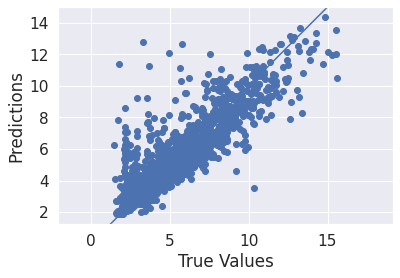

In [51]:
test_predictions = model_nn.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

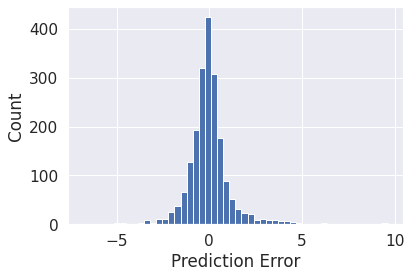

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")